# Apprentissage des réseaux profonds

En vous inspirant de : https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

Ecrire un programme qui : 
- charge la base de données de caractères MNIST
- permet de visualiser les exemples contenus dans un batch
- définit un réseau MLP à trois couches avec les caractéristiques suivantes :
    - unecouches cachée de 25 neurones
    - fonction de coût : entropie croisée
    - fonction d’activation : sigmoïde
- apprend ce réseau sur la partition d’apprentissage (2 epochs)
- évalue les performances 

## 1. Importation des librairies

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

# choisir cpu ou gpu pour calcul
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
device = 'cpu' # Faster on the cpu for this small model on Mac (mps otherwise) 

Using mps device


## 2. Chargement des données d'apprentissage : la base MNIST

https://pytorch.org/vision/stable/datasets.html

In [13]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)



Affichez la première image de la base d'apprentissage

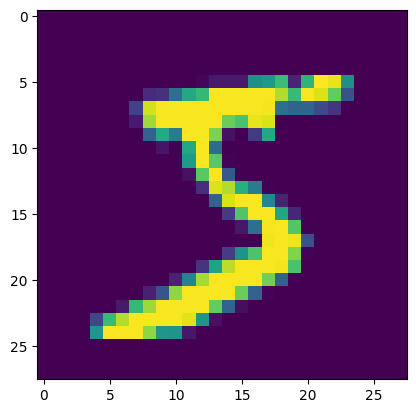

In [14]:
num_ex = 0
im_batch = training_data[num_ex][0]
im = im_batch[0].numpy()
plt.imshow(im)

Récupérez la dimension des images


In [15]:
height = im.shape[0]
width = im.shape[1]

print('height: {}\nwidth: {} '.format(height, width))

height: 28
width: 28 


Affichez son label associé

In [16]:
print('label : {}'.format(training_data[num_ex][1]))

label : 5


## 3. Conditionnement des données

Vérifier que les valeurs des pixels sont dans l'intervalle [0,1]

In [17]:
print("min : {}, max : {}".format(np.min(im) , np.max(im)))

min : 0.0, max : 1.0


## 3. Architecture du réseau 

Premier réseau - MLP à 1 couche cachée avec :
- en amont, une couche pour "applatir" les données 2D (flatten)
- 25 neurones sur la couche cachée
- des fonctions d'activation sigmoïde
- la fonction de coût erreur quadratique moyenne
- une optimisation par déscente de gradient stochastique (taux d'apprentissage $10^{-3}$ et momentum $0.9$)

In [18]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 25)
        # self.bn1 = nn.BatchNorm1d(25)  # BatchNorm après fc1
        self.fc2 = nn.Linear(25, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        # x = self.bn1(x)               # BatchNorm Normalisation
        x = torch.sigmoid(x)
        x = self.fc2(x)
        return x


mnist_model = MNISTModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mnist_model.parameters(), lr=0.05)
# optimizer = optim.Adagrad(mnist_model.parameters(), lr=0.01) # Pour utiliser AdaGrad

# Comparaison avec Adam - la correction des biais permet un démarrage plus rapide
# optimizer = optim.Adam(mnist_model.parameters(), lr=0.001, betas=(0.9, 0.999))
# Les facteurs betas=(0.9, 0.999) sont les valeurs par défaut
# La correction des biais évite les pas trop petits au début de l'entraînement

On affiche l'architecture du réseau

In [19]:
print(mnist_model)

MNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


## 4. Apprentissage du réseau

Avec des batchs de taille 64 et 10 epochs

In [20]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

num_epochs = 10
losses = []
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = mnist_model(data)
        # converti automatiquement les labels dans targets en vecteur one hot
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    #loss calculé uniquement sur le dernier batch de l'epoch
    print('epoch {}: {} (last batch)'.format(epoch, loss.item()))

epoch 0: 0.9431130290031433 (last batch)
epoch 1: 0.4567224979400635 (last batch)
epoch 2: 0.34598293900489807 (last batch)
epoch 3: 0.41041621565818787 (last batch)
epoch 4: 0.23578065633773804 (last batch)
epoch 5: 0.32088539004325867 (last batch)
epoch 6: 0.2885805070400238 (last batch)
epoch 7: 0.2346680462360382 (last batch)
epoch 8: 0.38142240047454834 (last batch)
epoch 9: 0.33084896206855774 (last batch)


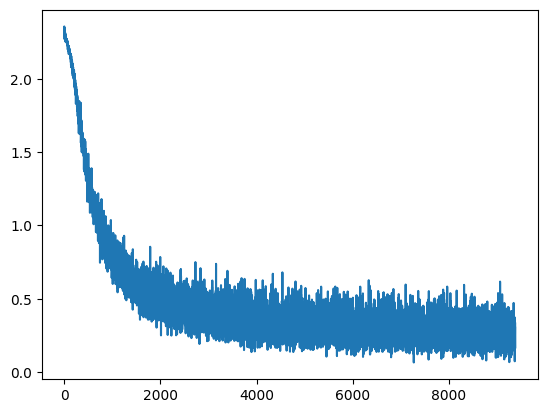

In [21]:
plt.plot(losses)

## 5. Evaluation du modèle sur la base de test

__Attention__ : en toute rigueur, l'evaluation devrait être menée sur une base de validation (fragment de la base de d'apprentissage)

In [22]:
# Évaluation du modèle
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        outputs = mnist_model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print("Test accuracy:", correct / total)

Test accuracy: 0.9276


## 6. Visualisation des poids du réseau

On récupère la liste des poids de la première couche du réseau. Il est possible de visualiser les poids de chaque neurone sous forme d'images. Pourquoi ? 
Afficher les poids des 25 premiers neurones de cette couche. Peut-on interpréter ces résultats ?

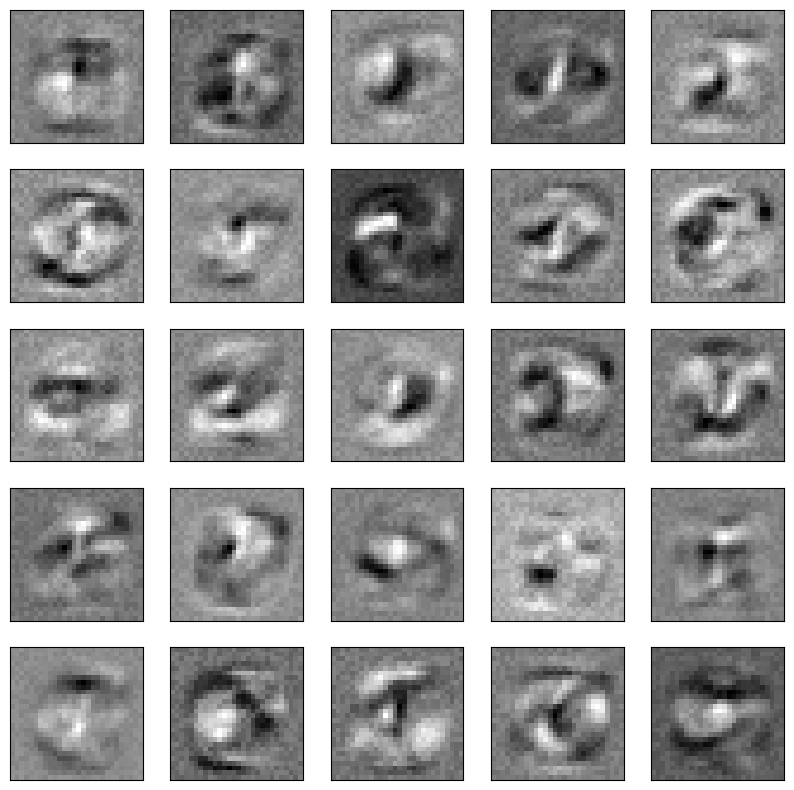

In [23]:
weights = mnist_model.fc1.weight.data.numpy()

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    vis = np.reshape(weights[i, :], (28, 28))
    plt.imshow(vis, cmap=plt.cm.binary)
plt.show()

On peut visualiser ces poids. Comment peut-on interpréter ces images ?

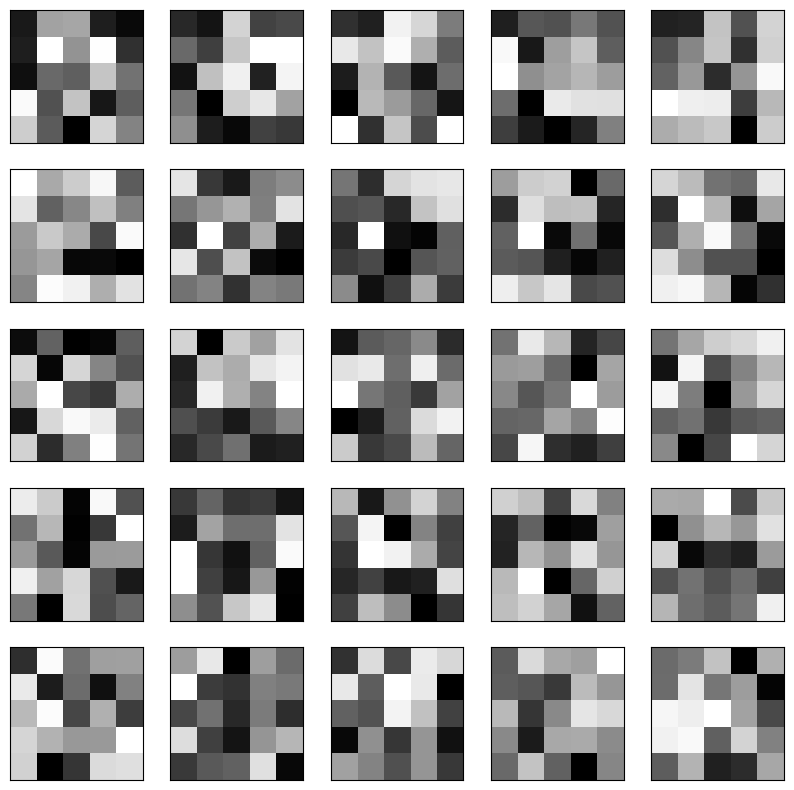

In [24]:
h = 5
w = 5
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    vis = np.reshape(weights[:,i],(h,w))
    plt.imshow(vis, cmap=plt.cm.binary)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

## 7. A faire

1) Evaluer l'influence sur les performances et les "images des poids" lorsque l'on augmente d'un facteur 10 :
- le nombre d'epochs
- le pas d'apprentissage

2) Tester la fonction de cout entropie croisée

3) Tester la fonction d'activation softmax sur la dernière couche

4) Améliorer encore les performances du réseau en :
- Augmentant le nombre de neurones sur la couche cachée
- Augmentant la profondeur du réseau
- Changeant la méthode d'optimisation 
- Utilisant la normalisation par batch (batch norm)

Reporter la justesse (accuracy) pour les différentes architectures testées